In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from unsupervised_bias_detection.cluster import BiasAwareHierarchicalKModes

#### A. Load data and data preparation

##### A.1 Load data

In [6]:
# Load the COMPAS dataset
file_path = "./compas-scores-two-years.csv"  # Replace with the actual path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


##### 0.2 Data cleaning

In [7]:
# Check for missing values
print(df.isnull().sum())

# Select relevant columns
columns_of_interest = ["age_cat", "sex", "race", "c_charge_degree", "is_recid", "score_text"]
filtered_df = df[columns_of_interest]

# Drop rows with missing values
filtered_df = filtered_df.dropna()

filtered_df.head()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

,age_cat,sex,race,c_charge_degree,is_recid,score_text
0,Greater than 45,Male,Other,F,0,Low
1,25 - 45,Male,African-American,F,1,Low
2,Less than 25,Male,African-American,F,1,Low
3,Less than 25,Male,African-American,F,0,High
4,25 - 45,Male,Other,F,0,Low


**UI text #1** (only for demo dataset)

**Information about demo dataset**

As a demo, a subset of the [COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) dataset](https://github.com/propublica/compas-analysis/tree/master) is loaded below. The dataset contains features about criminal defendants and their risk of recidivism as predicted by the COMPAS algorithm. It includes demographic details such as age, sex, and race, as well as criminal history, charge details, and the COMPAS risk label. This dataset is as a benchmark for studying algorithmic discrimination. A description of all variables can be found in the table below.

**Variable description**
+-----------------+-----------------------------------+----------------------------------------+
| Variable name   | Description                       | Values                                 |
+-----------------+-----------------------------------+----------------------------------------+
| age_cat         | Age category                      | Less than 25, 25-45, Greater than 45   |
+-----------------+-----------------------------------+----------------------------------------+
| sex             | Sex                               | Male, Female                           |
+-----------------+-----------------------------------+----------------------------------------+
| race            | Race                              | African-American, Asian, Caucasian,    |
|                 |                                   | Hispanic, Native American, Other       |
+-----------------+-----------------------------------+----------------------------------------+
| c_charge_degree | Severity level of the criminal    | M: Misdemeanor – Less severe offenses, |
|                 | charge                            | F: Felony – More serious crimes        |
+-----------------+-----------------------------------+----------------------------------------+
| is_recid        | If defendant reoffended           | 0: No, 1: Yes                          |
+-----------------+-----------------------------------+----------------------------------------+
| score_text      | Predicted risk label of defendant | 0: Not high risk, 1: High risk         |
+-----------------+-----------------------------------+----------------------------------------+



**UI text #2**

In this example, we analyze which group is most adversely affected by the risk prediction algorithm. We do this by applying the clustering algorithm on the dataset previewed below. `score_text` (1: high risk, 0: not high risk) is selected as a bias metric. A description of all variables can be found in the below table.

**0. Preview of data**

[below table with top-5 rows]

In [14]:
# map bias metric (score text) to binary values
filtered_df["score_text"] = filtered_df["score_text"].map(lambda x: 1 if x == "High" else 0)
filtered_df["is_recid"] = filtered_df["is_recid"].astype("category")
filtered_df.head()

,age_cat,sex,race,c_charge_degree,is_recid,score_text
0,Greater than 45,Male,Other,F,0,0
1,25 - 45,Male,African-American,F,1,0
2,Less than 25,Male,African-American,F,1,0
3,Less than 25,Male,African-American,F,0,0
4,25 - 45,Male,Other,F,0,0


In [21]:
from sklearn.preprocessing import OrdinalEncoder

# Apply OrdinalEncoder to the categorical columns
encoder = OrdinalEncoder()
filtered_df[filtered_df.columns] = encoder.fit_transform(filtered_df)

# Display the transformed DataFrame
filtered_df.head()

,age_cat,sex,race,c_charge_degree,is_recid,score_text
0,1.0,1.0,5.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0
2,2.0,1.0,0.0,0.0,1.0,0.0
3,2.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,5.0,0.0,0.0,0.0


##### A.3 Explanatory data analysis

In [22]:
dim = filtered_df.shape
print(dim)
n = dim[0]

(7214, 6)


In [23]:
# Example: Group by race to see recidivism rates
recidivism_rates = df.groupby("race")["two_year_recid"].mean()
print(recidivism_rates)

race
African-American    0.514340
Asian               0.281250
Caucasian           0.393643
Hispanic            0.364207
Native American     0.555556
Other               0.352785
Name: two_year_recid, dtype: float64


**UI text #3**

**1. Paramters selected for clustering**

- Number of iterations: {n_iter}
- Minimal cluster size: {n_iter}
- Bias metric: {bias_metric}
- Data type: [TO DO]

#### B. Split dataset in train and test set

In [24]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (5771, 6)
Testing set shape: (1443, 6)


**UI text #4**

**2. Splitting dataset**

To reduce noise detection, the dataset is split in a train (80%) and test dataset (20%). The clustering method if fitted on the train dataset. The presence of statistically significant bias in deviating clusters is then evaluated using the test dataset.

- Training set shape: {train_df.shape[0]}
- Testing set shape: {test_df.shape[0]}

#### C. Fitting HBAC - kmodes

Note that ```n_iter``` and ```min_cluster``` can be specified by the user in the web app

In [25]:
X = train_df.drop(columns=["score_text"])
y = train_df["score_text"]
hbac = BiasAwareHierarchicalKModes(bahc_max_iter=20, bahc_min_cluster_size=n*0.10).fit(X, y)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but BiasAwareHierarchicalClustering was fitted without feature names
  warnings.warn(


TypeError: '<' not supported between instances of 'ClusterNode' and 'ClusterNode'

In [ ]:
# number of clusters
hbac.n_clusters_

4

In [17]:
# bias metric scores
hbac.scores_

array([ 0.06562301,  0.02851334, -0.00819492, -0.20764978])

**3. Clustering results**

- Number of clusters detected: {hbac.n_clusters_}
- Number of datapoint is most deviating cluster: 
- Most deviating cluster (in terms of bias metric) is statistically significant: 

In [23]:
hbac.labels_

array([2, 3, 1, ..., 2, 1, 3], dtype=uint32)

In [14]:
filtered_df["cluster_label"] = hbac.labels_

ValueError: Length of values (5771) does not match length of index (7214)

In [ ]:
grouped_data.index.to_list()

NameError: name 'grouped_data' is not defined

In [ ]:
range(len(grouped_data.index))

range(0, 4)

In [ ]:
grouped_data.index.to_list()

[0, 1, 2, 3]

In [ ]:
grouped_data

age_cat,25 - 45,Greater than 45,Less than 25
cluster_label,,,
0,278,703,438
1,3080,647,519
2,751,73,96
3,0,153,476


In [ ]:
percentages.T

cluster_label,0,1,2,3
sex,,,,
Female,19.802678,11.610928,67.5,0.0
Male,80.197322,88.389072,32.5,100.0


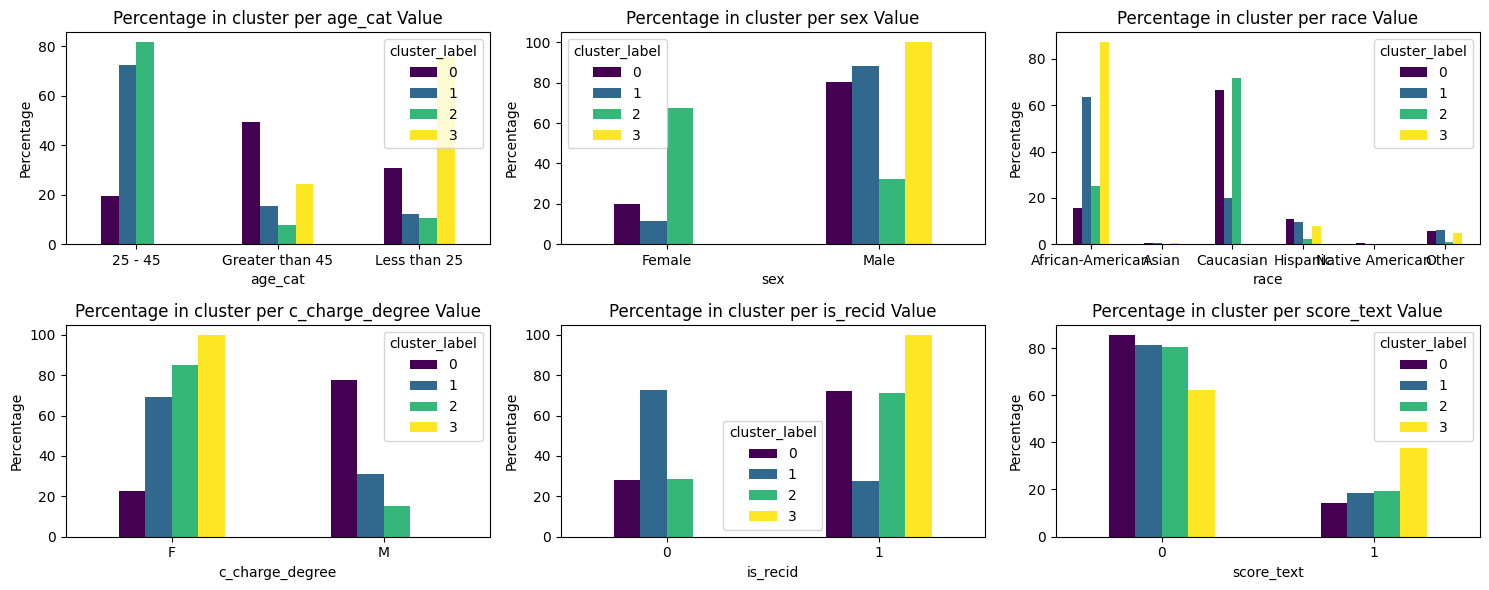

In [ ]:
# Define the columns to analyze
columns_to_analyze = ["age_cat", "sex", "race", "c_charge_degree", "is_recid", "score_text"]

# Create subplots for each column
rows = (len(columns_to_analyze) + 2) // 3  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, min(len(columns_to_analyze), 3), figsize=(15, 3 * rows), squeeze=False)
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, column in enumerate(columns_to_analyze):
    # Group by cluster_label and the column, then calculate percentages
    grouped_data = filtered_df.groupby(["cluster_label", column]).size().unstack(fill_value=0)
    percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
    
    # Plot the percentage data
    percentages.T.plot(kind="bar", ax=axes[i], colormap="viridis")
    axes[i].set_title(f"Percentage in cluster per {column} Value")
    axes[i].set_ylabel("Percentage")
    axes[i].set_xticklabels(percentages.T.index, rotation=0)

plt.tight_layout()
plt.show()